# PS reconstruction, Gaussian beam

In [1]:
import torch
import numpy as np
from copy import deepcopy

import lightning as L
from cheetah.particles import ParticleBeam
from cheetah.utils.bmadx import bmad_to_cheetah_coords
from cheetah.accelerator import Quadrupole, Drift

from gpsr.diagnostics import ImageDiagnostic
from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator


## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6 # reference momentum in eV/c

gt_beam = torch.load("../example_data/example_distributions/gaussian_beam.pt")


/tmp/ipykernel_1735117/1967565233.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gt_beam = torch.load("../example_data/example_distributions/gaussian_beam.pt")


## Define diagnostics lattice parameters

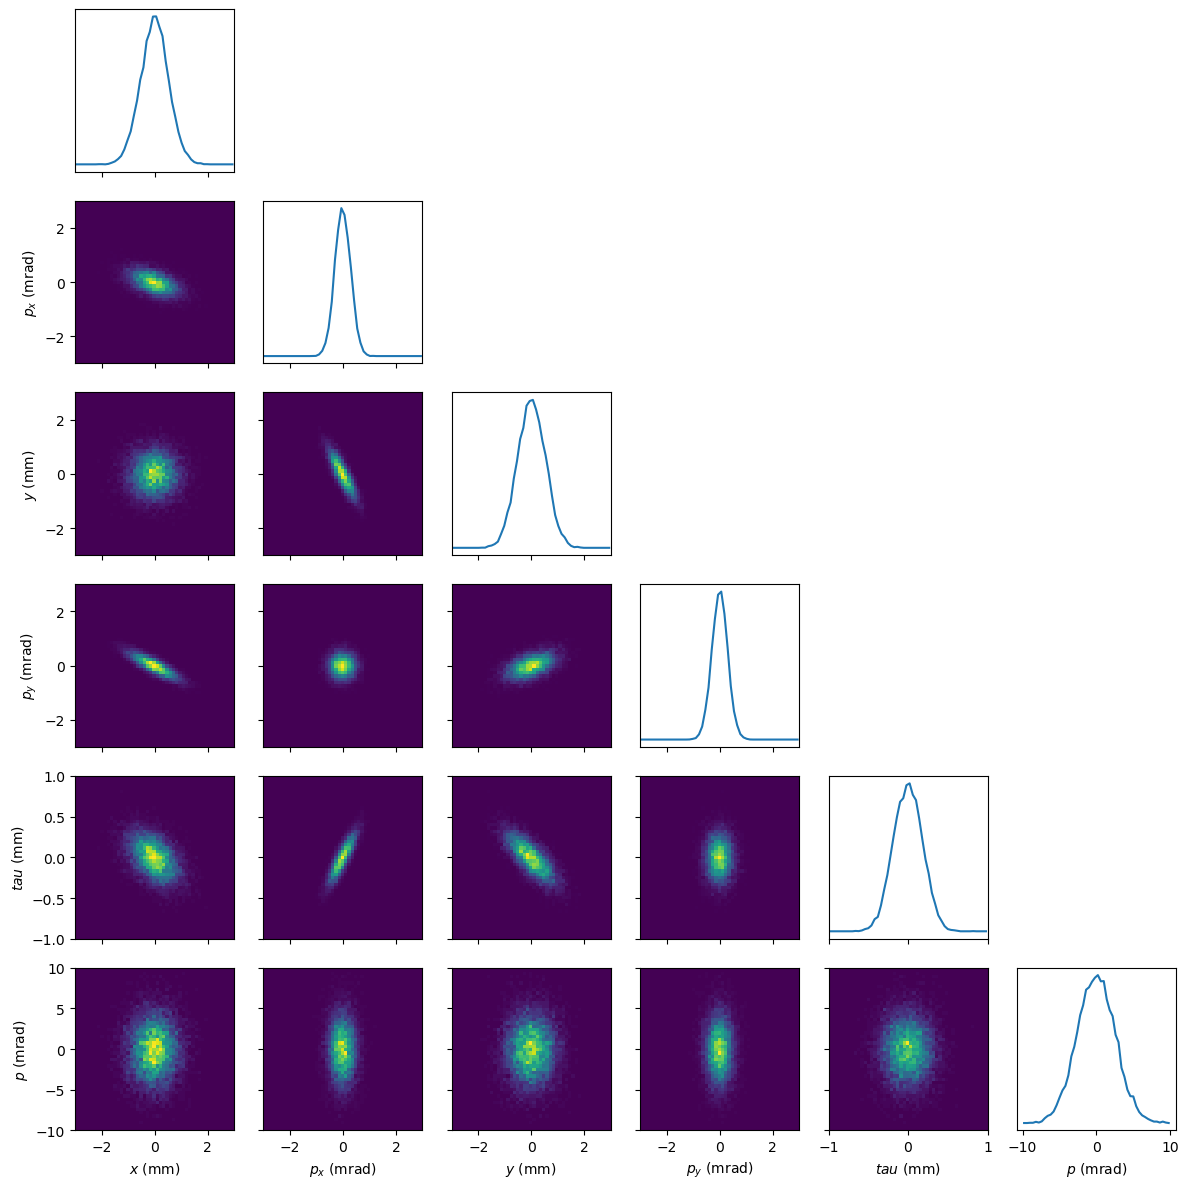

In [3]:
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) *0.2
gt_beam.plot_distribution(custom_lims = lims);

In [4]:
# create diagnostic screens:
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

Cheetah based version

In [5]:
# define upstream beamline
k1 =            -24.868402
k2 =             26.179029
k3 =            -26.782126

quad_length = 0.11
lq12 = 1.209548
lq23 = 0.19685
lq34 = 0.18415
ld1 = lq12 - quad_length
ld2 = lq23 - quad_length
ld3 = lq34 - quad_length
q1 = Quadrupole(
    length=quad_length,
    k1=k1,
    num_steps=5,
    tracking_method="bmadx"
)
d1 = Drift(ld1)
q2 = Quadrupole(
    length=quad_length,
    k1=k2,
    num_steps=5,
    tracking_method="bmadx"
)
d2 = Drift(ld2)
q3 = Quadrupole(
    length=quad_length,
    k1=k3,
    num_steps=5,
    tracking_method="bmadx"
)
d3 = Drift(ld3)
upstream_components = [q1, d1, q2, d2, q3, d3]

l_quad=0.11
l_tdc=0.01
f_tdc=1.3e9
phi_tdc=0.0
l_bend=0.3018
theta_on=- 20.0 * 3.14 / 180.0
l1=0.790702
l2=0.631698
l3=0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
    upstream_components
)



In [6]:
# Scan over quad strength, tdc on/off and dipole on/off
n_ks = 5
PI = 3.14
ks = torch.linspace(-3, 3, n_ks) # quad ks
vs = torch.tensor([0, 3e6]) # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0*PI/180.0/0.365]) # dipole off/on

scan_ids = [6, 8, 10]
n_ks = 5

train_params = torch.meshgrid(gs, vs, ks, indexing='ij')
train_params = torch.stack(train_params, dim=-1)

# create training data
gpsr_lattice.set_lattice_parameters(train_params)
final_beam = gpsr_lattice.lattice(gt_beam)
obs = gpsr_lattice.track_and_observe(gt_beam)

obs_dataset = SixDReconstructionDataset(train_params, obs, (bins, bins))

In [7]:
torch.save(obs_dataset, "../example_data/example_datasets/reconstruction_6D.dset")

/global/common/software/m669/jpga/conda/envs/gpsr/lib/python3.13/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1730833640211/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


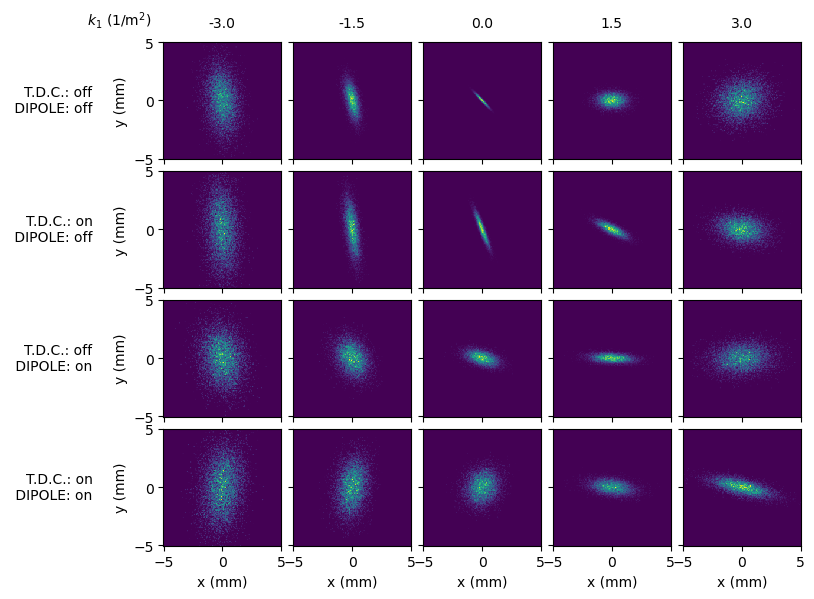

In [8]:
fig, ax = obs_dataset.plot_data(publication_size=True)

## Training using pytorch lightning

In [9]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger('.', )
trainer = L.Trainer(limit_train_batches=100,max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable param

Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, v_num=3]


In [10]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

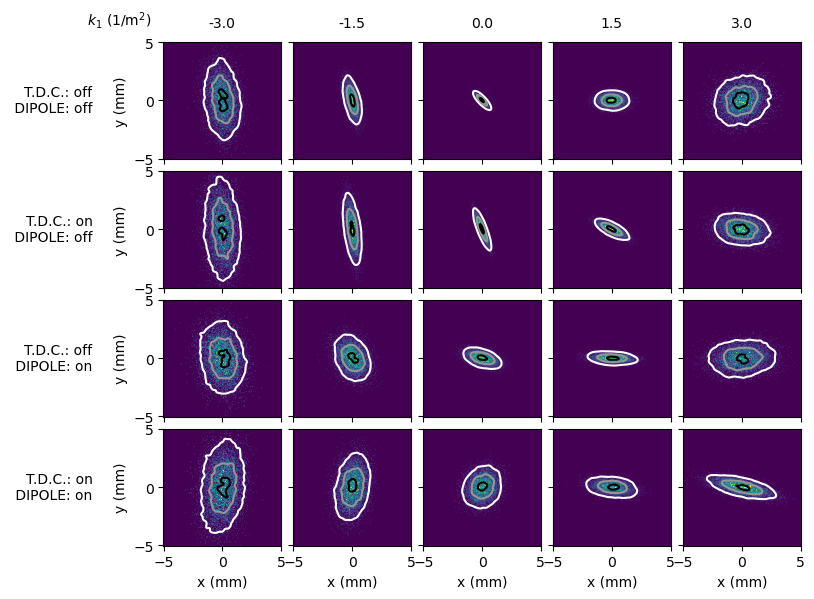

In [11]:
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(train_params, pred, (bins, bins))
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap":"Greys","levels":[0.1,0.5,0.9]}
);


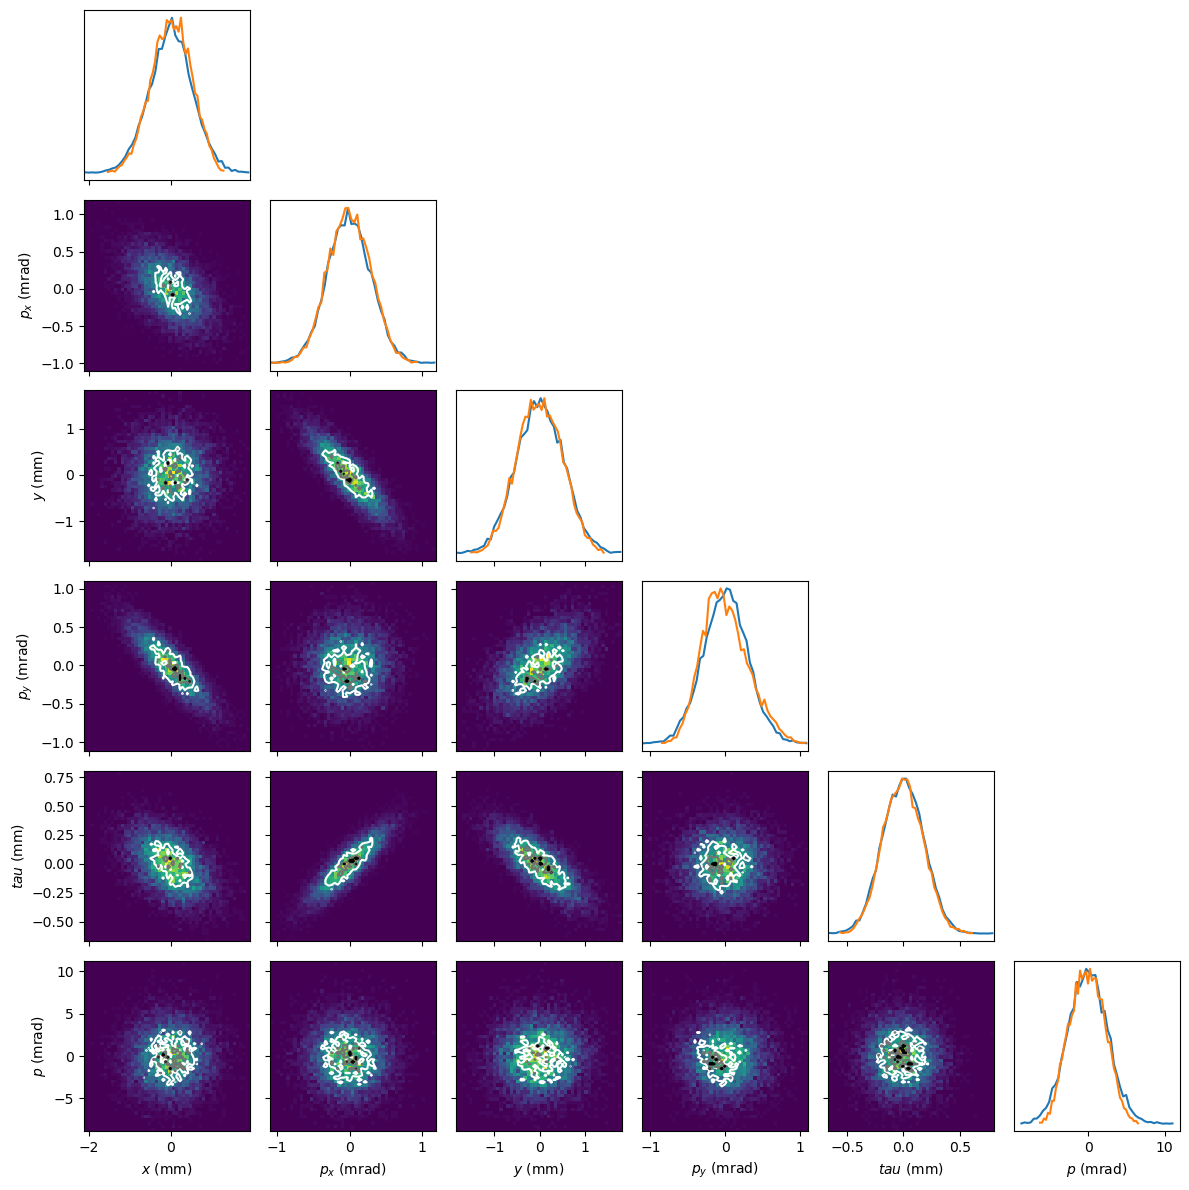

In [12]:
from gpsr.visualization import compare_beams
compare_beams(gt_beam, reconstructed_beam, levels=[0.5,0.75,0.9]);